# RECS Energy Data
**This data is from the US Energy Information Administration from their Residential Energy Consumption Survey (RECS)**
This specific data set was collected in 2015, and is the 14th iteration of the RECS program that started in 1978. The data is collected from over 5,600 households and is extrapolated to represent 118.2 million American households.

The raw data can be found here: https://www.eia.gov/state/?sid=MA

I found a review of the data by a separate source that I used as a bias checker to see if there were any errors in the data that I should be aware of. It included some of the methodology, and examples of smaller errors that I don't think influence the ethicallity of the study.

https://www.aeaweb.org/forum/1597/energy-economists-invites-comment-residential-consumption

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn import datasets 
from sklearn.datasets import fetch_openml 
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from itertools import combinations, chain

plt.style.use("fivethirtyeight")

# Importing data set
file = 'recs2015_public_v4.csv'
raw_df = pd.read_csv(file)

## About the dataset 
The first 480 rows are categorical (1 for yes, 0 for no, or regions in 0, 1, 2, 3, etc.). Rows 580 tp 740 are numeric values for various quantity. 

### Useful Variables from the Dataset

| Name Used  | Definition | |
| ------------- | ------------- | -- |
| NHSLDMEM  | number of household members  |
| MONEYPY  | Annual gross household income for the last year | (1 to 8) Bins of 20,000 starting at 0-20,000 and ending at 140,000 or more|
| KWH | total electricity usage in kilowatthours |
| KWHSPH | Electricity usage for space heating in kilowatthours | | TOTALDOLSPH | Total cost for space heating in dollars |
| TOTALBTUSPH | Total usage for space heating, main and secondary, in thousand Btu |
| TOTHSQFT | total heated square footage |
| TOTROOMS | Total number of rooms in the housing unit, excluding bathrooms |
| WINDOWS | Number of windows |
| BTUxxSPH | energy usage (in thousand BTU) used for xx space heating | EL = ELECTRIC, LP = PROPANE, NG = NATURAL GAS, FO = FUEL OIL/KEROSENE |
| DOLxxSPH | cost (in dollars) for xx space heating | EL = ELECTRIC, LP = PROPANE, NG = NATURAL GAS, FO = FUEL OIL/KEROSENE |
| HOUSEHOLDER_RACE | Householder (respondant) race | (1 to 7) 1 = White, 2 = Black/African American, 3 = Indigenous, 4 = Asian, 5 = Native Hawaiian or Pacific Islander, 6 = Other, 7 = 2 or More Races Selected |
| DIVISION | Census Division | (1 to 10) NE, Mid Atlantic, East North Central, West North Central, South Atlantic, East South Central, West South Central, Mountain North, Mountain South, Pacific |
| REGIONC | Census Region | (1 to 4) Northeast, Midwest, South, West |
| YEARMADERANGE | Range when housing unit was built | (1 to 8) Bins of 10 years starting with before 1950 ending with 2010-2015 |

In [2]:
# Here I select the useful variables from the full data set into a smaller one.
# This will improve efficiency because we are working with a smaller set of data
df = raw_df[["KWH","TOTALDOLSPH","TOTALBTUSPH","NHSLDMEM","TOTHSQFT","YEARMADERANGE",
             "DOLELSPH","BTUELSPH","DOLNGSPH", "BTUNGSPH","DOLLPSPH", 
             "BTULPSPH","DOLFOSPH", "BTUFOSPH", 
             "MONEYPY","ELWARM","UGWARM","LPWARM","WINDOWS", "TYPEHUQ", 
             "REGIONC", "DIVISION", "TOTROOMS", 'HOUSEHOLDER_RACE']]

# The header helps to visualize what the data looks like
df.head()

,KWH,TOTALDOLSPH,TOTALBTUSPH,NHSLDMEM,TOTHSQFT,YEARMADERANGE,DOLELSPH,BTUELSPH,DOLNGSPH,BTUNGSPH,...,MONEYPY,ELWARM,UGWARM,LPWARM,WINDOWS,TYPEHUQ,REGIONC,DIVISION,TOTROOMS,HOUSEHOLDER_RACE
0,5270.742,176.59,12469.727,4,1808,7,0.00,0.000,176.59,12469.727,...,8,0,1,0,41,2,4,10,7,1
1,12173.000,380.52,11570.020,2,759,5,380.52,11570.020,0.00,0.000,...,2,1,0,0,20,2,3,7,4,1
2,19655.394,601.17,23499.517,4,1430,4,451.12,12460.003,150.06,11039.514,...,2,1,1,0,41,2,3,6,9,1
3,9852.535,863.46,52408.189,1,2573,2,188.22,4818.534,0.00,0.000,...,3,1,0,1,42,2,2,4,7,3
4,3115.655,67.87,5339.841,3,933,4,0.00,0.000,67.87,5339.841,...,3,0,1,0,30,2,1,2,6,4


In [3]:
# This was to see if I had enough data to use only data from NE households

print("total number of data {}".format(len(df)))
print("the number of data for New England {}".format(len(df[df.DIVISION==1])))
print("the number of data for Pacific {}".format(len(df[df.DIVISION==10])))

# I deduced that 253 data points was sufficient for prediction

total number of data 5686
the number of data for New England 253
the number of data for Pacific 1085


## Cleaning Data

Here, I check if any values in the smaller data set are null. Null would mean there are missing values. 

In [4]:
df[df.isnull().any(axis=1)]

,KWH,TOTALDOLSPH,TOTALBTUSPH,NHSLDMEM,TOTHSQFT,YEARMADERANGE,DOLELSPH,BTUELSPH,DOLNGSPH,BTUNGSPH,...,MONEYPY,ELWARM,UGWARM,LPWARM,WINDOWS,TYPEHUQ,REGIONC,DIVISION,TOTROOMS,HOUSEHOLDER_RACE


Because .isnull() does not return any rows, none of the data is missing. 

First, I made a histogram for TOTALDOLSPH (total dollars spent on space heating) to see if any of the values seems suspect.

Text(0, 0.5, 'Number of Households')

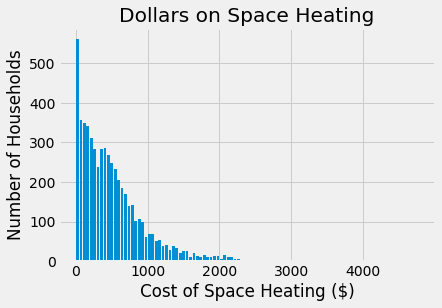

In [5]:
plt.hist(df.TOTALDOLSPH, bins=100, rwidth=.8)
plt.title('Dollars on Space Heating');
plt.xlabel("Cost of Space Heating ($)")
plt.ylabel("Number of Households")

 The large number of households that spend 0 dollars on space heating seems suspect. However, those households likely do not use space heating or have internal space heaters that do not contribute to their costs. 

I noticed that there is a dip around 300 dollars. Besides this, the trend seems pretty consistent. I will separate people that use electricity vs propane vs natural gas for space heating to see if that contributes to the discrepancy.

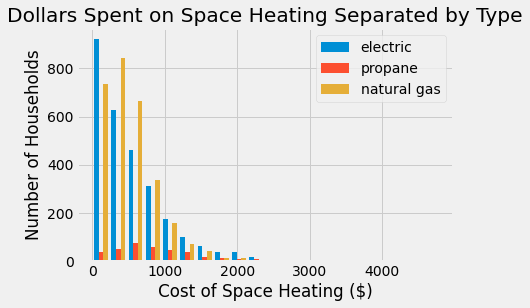

In [6]:
electric = df[df.ELWARM == 1]
propane = df[df.LPWARM == 1]
natural_gas = df[df.UGWARM == 1]
# Does not yet include other sources of fuel
# other = df[[df.ELWARM == 0],[df.UGWARM == 0],[df.LPWARM == 0]]

plt.hist([electric.TOTALDOLSPH, propane.TOTALDOLSPH, natural_gas.TOTALDOLSPH],  
         label=['electric', 'propane', 'natural gas'], 
         bins=20)
plt.legend()
plt.title('Dollars Spent on Space Heating Separated by Type');
plt.xlabel("Cost of Space Heating ($)")
plt.ylabel("Number of Households")
plt.show()
# The different sources of fuel have different trends. The peaks are at different places.

I separated the data for each type of electricity used for space heating and plotted them on the same histogram. Here, I can clearly see different trends for different types of energy used. Households that use electricity for space heating show a trend similar to logistic regression, and propane and natural gas have peaks around 500. It is interesting that a significant number of the households that use electricity also pay 0 dollars for space heating. I wonder why this is? Perhaps electricity is a cheaper alternative.

Because there are different trends for types of electricity, kwh could be a predictor for type of energy used. This is what I used to try to predict type of heating which is included at the bottom of the file. 

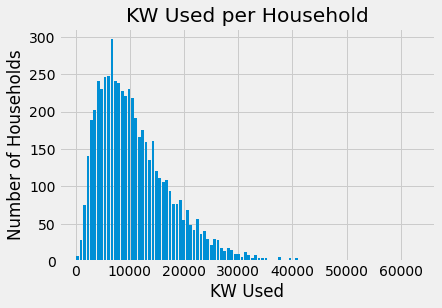

In [7]:
plt.hist(df.KWH, bins=100, rwidth=.8)
plt.xlabel("KW Used")
plt.ylabel("Number of Households")
plt.title('KW Used per Household');

I thought that the spike around 8000 was a little suspect. I thought this could be due to just a large mode because there was an optimal amount of energy that could be used, or because they were missing values that were filled in to the the median. 

(array([20., 21., 20., 23., 26., 22., 21., 23., 22., 24., 28., 22., 18.,
        20., 20., 21., 21., 22., 25., 22., 26., 25., 26., 16., 27., 16.,
        32., 18., 25., 20., 20., 18., 30., 22., 28., 30., 26., 26., 15.,
        19., 39., 33., 23., 26., 24., 22., 33., 27., 33., 28., 25., 27.,
        21., 15., 14., 23., 27., 25., 22., 30., 18., 27., 23., 26., 29.,
        21., 17., 21., 20., 27., 19., 23., 23., 23., 26., 21., 19., 24.,
        14., 27., 23., 13., 19., 20., 17., 20., 20., 28., 19., 21., 20.,
        26., 33., 22., 12., 19., 22., 22., 34., 25.]),
 array([4002.041  , 4062.01459, 4121.98818, 4181.96177, 4241.93536,
        4301.90895, 4361.88254, 4421.85613, 4481.82972, 4541.80331,
        4601.7769 , 4661.75049, 4721.72408, 4781.69767, 4841.67126,
        4901.64485, 4961.61844, 5021.59203, 5081.56562, 5141.53921,
        5201.5128 , 5261.48639, 5321.45998, 5381.43357, 5441.40716,
        5501.38075, 5561.35434, 5621.32793, 5681.30152, 5741.27511,
        5801.2487 , 5861.2

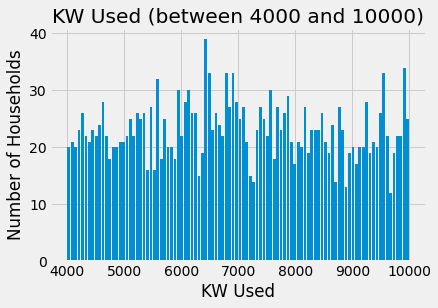

In [8]:
# I used a smaller range to check the mode in KWH.

kw_small = df[df.KWH < 10000]
kw_smalll = kw_small[kw_small.KWH > 4000]
plt.xlabel("KW Used")
plt.ylabel("Number of Households")
plt.title('KW Used (between 4000 and 10000)')
plt.hist(kw_smalll['KWH'], bins=100, rwidth=.8)

# However, the data seems to be relatively distributed within that range, so I do not think that those are missing values.

## Cost Efficiency Analysis of Space Heating Methods
Here, I graphed energy used for space heating vs cost of space heating. I used colors to differentiate what primary source of energy the houshold used for space heating.

I decided to split the data between NE and Pacific to see if there was any significant difference.

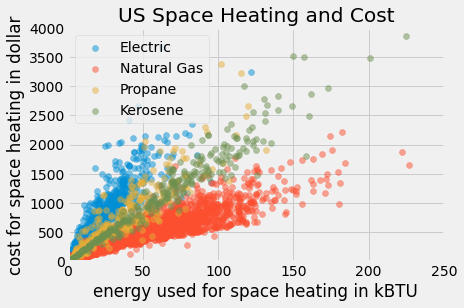

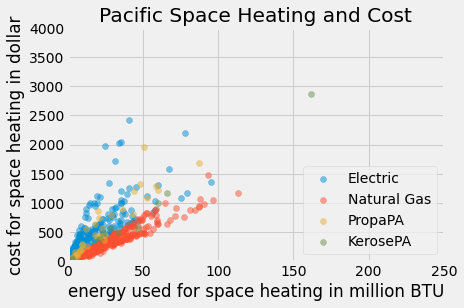

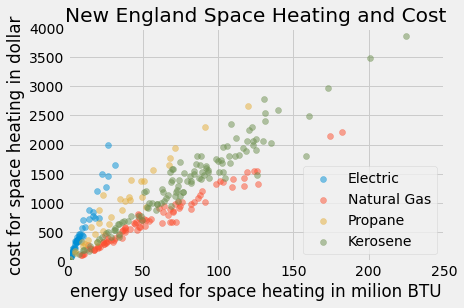

In [9]:
EL = plt.scatter(df["BTUELSPH"]/1000, df["DOLELSPH"], alpha = .5)
NG = plt.scatter(df['BTUNGSPH']/1000, df['DOLNGSPH'], alpha = .5)
LP = plt.scatter(df['BTULPSPH']/1000, df['DOLLPSPH'], alpha = .5)
FO = plt.scatter(df['BTUFOSPH']/1000, df['DOLFOSPH'], alpha = .5)

plt.legend((EL, NG, LP, FO), ('Electric', 'Natural Gas', 'Propane', 'Kerosene'))
plt.xlabel("energy used for space heating in kBTU")
plt.ylabel("cost for space heating in dollar")
plt.title("US Space Heating and Cost")
plt.xlim(0, 250)
plt.ylim(0, 4000)
plt.show()

PA = df[df.DIVISION == 10]

EL = plt.scatter(PA["BTUELSPH"]/1000, PA["DOLELSPH"], alpha = .5)
NG = plt.scatter(PA['BTUNGSPH']/1000, PA['DOLNGSPH'], alpha = .5)
LP = plt.scatter(PA['BTULPSPH']/1000, PA['DOLLPSPH'], alpha = .5)
FO = plt.scatter(PA['BTUFOSPH']/1000, PA['DOLFOSPH'], alpha = .5)

plt.legend((EL, NG, LP, FO), ('Electric', 'Natural Gas', 'PropaPA', 'KerosePA'), loc=4)
plt.xlabel("energy used for space heating in million BTU")
plt.ylabel("cost for space heating in dollar")
plt.title("Pacific Space Heating and Cost")
plt.xlim(0, 250)
plt.ylim(0, 4000)

plt.show()

NE = df[df.DIVISION == 1]

EL = plt.scatter(NE["BTUELSPH"]/1000, NE["DOLELSPH"], alpha = .5)
NG = plt.scatter(NE['BTUNGSPH']/1000, NE['DOLNGSPH'], alpha = .5)
LP = plt.scatter(NE['BTULPSPH']/1000, NE['DOLLPSPH'], alpha = .5)
FO = plt.scatter(NE['BTUFOSPH']/1000, NE['DOLFOSPH'], alpha = .5)

plt.legend((EL, NG, LP, FO), ('Electric', 'Natural Gas', 'Propane', 'Kerosene'), loc=4)
plt.xlabel("energy used for space heating in milion BTU")
plt.ylabel("cost for space heating in dollar")
plt.title('New England Space Heating and Cost')
plt.xlim(0, 250)
plt.ylim(0, 4000)

plt.show()

 I found that households in NE use significantly more energy and money on space heating than households in the Pacific. This makes sense because NE has colder winters that require more heating. It is interesting to consider that climate may shift these costs away from NE if NE winters become warmer. 

Because there was a significant difference between NE and Pacific households, I chose to focus solely on NE households.

For both NE and Pacific, natural gas was the most cost efficient method of space heating, and electric was the least cost efficient. Thus, it makes sense that more housholds in NE choose to use natural gas for their space heating. However, in the Pacific, perhaps because cost for space heating is lower overall, people do not have a strong preference for natural gas and there are more housholds that use electric space heating.

## Energy Usage and Income

I wanted to see if income impacted the amount of energy a household uses for space heating. I thought that households with a greater income would use more energy to heat their homes because they may have larger homes and have the resources to keep their home heated more consistently. I also wanted to see if this difference was proportional or less than proportional to income by plotting income vs cost of heating/income.

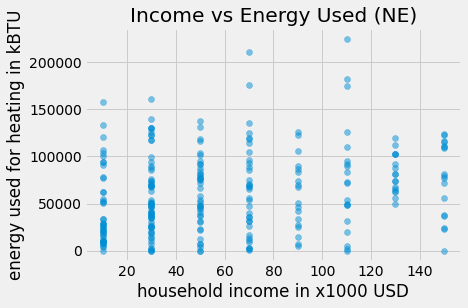

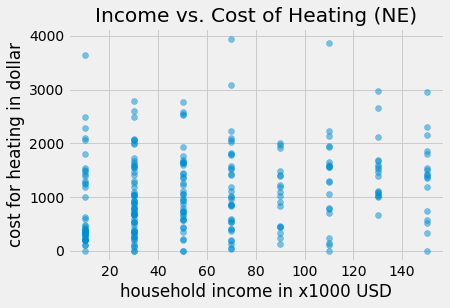

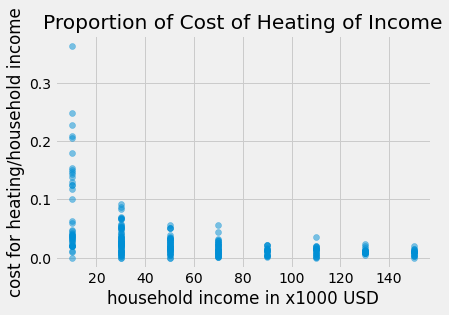

In [10]:
df2 = df.copy();

# calculate energy usage per Capita
df2['BTU_perCapita'] = df['TOTALBTUSPH']/df['NHSLDMEM']

# calculate fraction of energy by electric etc. 
df2['fEL'] = df["BTUELSPH"]/df['TOTALBTUSPH']
df2['fNG'] = df["BTUNGSPH"]/df['TOTALBTUSPH']
df2['fLP'] = df["BTULPSPH"]/df['TOTALBTUSPH']
df2['fFO'] = df["BTUFOSPH"]/df['TOTALBTUSPH']

# convert MONEYPY to household income in thousand dollars
df2['Income'] = (df['MONEYPY']-1)*20+10 

NE = df2[df.DIVISION == 1]

f_dol_sph = NE["TOTALDOLSPH"]/(NE['Income']*1000)

plt.scatter(NE['Income'], NE["TOTALBTUSPH"], alpha = .5)
plt.xlabel("household income in x1000 USD")
plt.ylabel("energy used for heating in kBTU")
plt.title('Income vs Energy Used (NE)')
plt.show()

plt.scatter(NE['Income'], NE["TOTALDOLSPH"], alpha = .5)
plt.xlabel("household income in x1000 USD")
plt.ylabel("cost for heating in dollar")
plt.title('Income vs. Cost of Heating (NE)')
plt.show()

plt.scatter(NE['Income'], f_dol_sph, alpha = .5)
plt.xlabel("household income in x1000 USD")
plt.ylabel("cost for heating/household income")
plt.title('Proportion of Cost of Heating of Income')
plt.show()


These graphs show that cost of space heating and energy used does not change significantly depending on income. Also, lower-income people spend significantly more of their income on heating. This is consistent with other expenses such as food and rent.

## Modeling Linear Regression

I used a linear regression model to predict energy used. Model 1 and Model 2 show two different predictions. This is because I used the second model to try if adding additional variables would make the prediction more or less accurate. The closer the points are to the x=y line, the more accurate the model is. (The closer the coefficient of determination of the model is to 1, the more accurate the model is.)

I also split the data into testing and training data to prevent overfitting.

Note: Using TOTALDOLSPH as a variable in the prediction makes it very accurate. However, this would not be the point of my project because if you knew the amount spent on heating you would also likely know the amount of energy used. I wantedto keep the prediction very accessible by using variables that most people know about their home. The best model I landed on used number of household members, income, year range that the house was made, total rooms, and number of windows. 

coefficient of determination model1: 0.417,  moldel2:0.457
intercept: 7600.71476221631
slope: [  210.19666502    14.87599081 -4398.00158321    21.19582574
  6385.85633518]


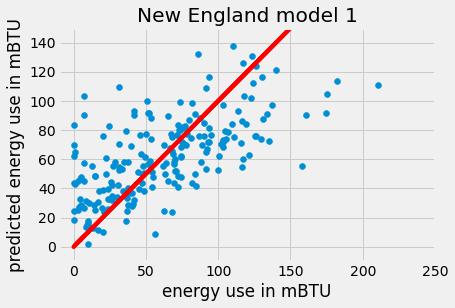

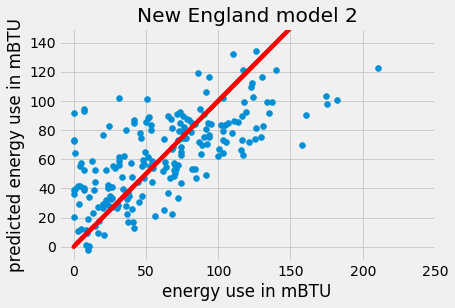

coefficient of determination model1: 0.207,  moldel2:0.241


In [11]:
# linear regression model

# Import the packages and classes needed in this example:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

x = NE[['NHSLDMEM', "TOTHSQFT", 'YEARMADERANGE', 'Income', 'TOTROOMS']] # "TOTALDOLSPH"
y = NE['TOTALBTUSPH']

x2 = NE[['NHSLDMEM',"TOTHSQFT",'Income', 'YEARMADERANGE', 'TOTROOMS', 'WINDOWS']] # ,"TOTALDOLSPH"

x_train, x_test, x2_train, x2_test, y_train, y_test = train_test_split(x,x2,y,test_size =0.2)

# Create an instance of a linear regression model and fit it to the data with the fit() function:
model = LinearRegression().fit(x_train, y_train) 
model2 = LinearRegression().fit(x2_train, y_train) 

# The following section will get results by interpreting the created instance: 

# Obtain the coefficient of determination by calling the model with the score() function, then print the coefficient:
r_sq = model.score(x_train, y_train)
r_sq2 = model2.score(x2_train, y_train)
print('coefficient of determination model1: {:.3f},  moldel2:{:.3f}'.format(r_sq, r_sq2))

# Print the Intercept:
print('intercept:', model.intercept_)
intercept = model.intercept_

# Print the Slope:
print('slope:', model.coef_) 
#coef = model.coef_

# Predict a Response and print it:
y_pred = model.predict(x_train)
y2_pred = model2.predict(x2_train)
#print('Predicted response:', y_pred, sep='\n')

plt.scatter(y_train/1000,y_pred/1000)
plt.xlabel("energy use in mBTU")
plt.ylabel("predicted energy use in mBTU")
plt.title('New England model 1')
plt.plot(x,x, color = 'r')
plt.xlim(-10, 250)
plt.ylim(-10, 150)
plt.show()

plt.scatter(y_train/1000,y2_pred/1000)
plt.xlabel("energy use in mBTU")
plt.ylabel("predicted energy use in mBTU")
plt.title('New England model 2')
plt.plot(x,x, color = 'r')
plt.xlim(-10, 250)
plt.ylim(-10, 150)
plt.show()

#print(model.predict([[1000], [1], [0], [0], [15], [5]]))
r_sq_test = model.score(x_test, y_test)
r_sq2_test = model2.score(x2_test, y_test)
print('coefficient of determination model1: {:.3f},  moldel2:{:.3f}'.format(r_sq_test, r_sq2_test))

## Residuals

### Heated Area Residual
I plotted residuals to see if the model was accurate. I started with just heated area of the house.

coefficient of determination model1: 0.261


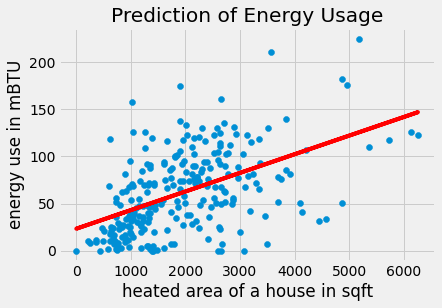

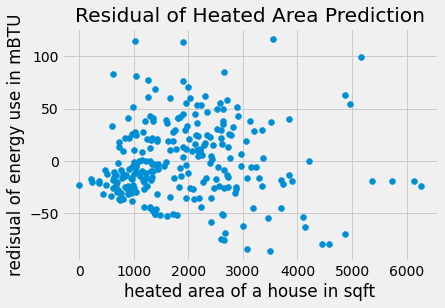

In [12]:

from sklearn.linear_model import LinearRegression
x = NE[["TOTHSQFT"]] # ,"TOTALDOLSPH"
y = NE['TOTALBTUSPH']

model = LinearRegression().fit(x, y) 

# The following section will get results by interpreting the created instance: 

# Obtain the coefficient of determination by calling the model with the score() function, then print the coefficient:
r_sq = model.score(x, y)
print('coefficient of determination model1: {:.3f}'.format(r_sq))

# Predict a Response and print it:
y_pred = model.predict(x)

y_residual = y-y_pred

plt.scatter(x,y/1000)
plt.plot(x,y_pred/1000, color = 'r')
plt.xlabel("heated area of a house in sqft")
plt.ylabel("energy use in mBTU")
plt.title('Prediction of Energy Usage')
plt.show()

plt.scatter(x, y_residual/1000)
plt.xlabel("heated area of a house in sqft")
plt.ylabel("redisual of energy use in mBTU")
plt.title('Residual of Heated Area Prediction')
plt.show()

The residuals seem randomly distributed. Thus, I think that there is no sytematic error.

In [13]:
# linear regression model ( This is to reevaluate)

# Import the packages and classes needed in this example:
import numpy as np
from sklearn.linear_model import LinearRegression


x = NE[['NHSLDMEM',"TOTHSQFT",'Income', 'YEARMADERANGE', 'TOTROOMS']] # ,"TOTALDOLSPH"
y = NE['TOTALBTUSPH']

x2 = NE[['NHSLDMEM',"TOTHSQFT",'Income', 'YEARMADERANGE', 'TOTROOMS', 'WINDOWS']] # ,"TOTALDOLSPH"

# Create an instance of a linear regression model and fit it to the data with the fit() function:
model = LinearRegression().fit(x, y) 
model2 = LinearRegression().fit(x2, y) 

# The following section will get results by interpreting the created instance: 

# Obtain the coefficient of determination by calling the model with the score() function, then print the coefficient:
r_sq = model.score(x, y)
r_sq2 = model2.score(x2,y)
print('coefficient of determination model1: {:.3f},  moldel2:{:.3f}'.format(r_sq, r_sq2))

# Print the Intercept:
print('intercept:', model.intercept_)
intercept = model.intercept_

# Print the Slope:
print('slope:', model.coef_) 
#coef = model.coef_

# Predict a Response and print it:
y_pred = model.predict(x)
y2_pred = model2.predict(x2)
#print('Predicted response:', y_pred, sep='\n')


coefficient of determination model1: 0.374,  moldel2:0.412
intercept: 10935.541684974152
slope: [  347.55197261    14.86603816    13.40985598 -4147.16514957
  5632.04441499]


### Window Residuals

Note that the number of windows is catagory, 10 is 1 to 2, 20 is 3 to 5 etc. 

type of dy is <class 'numpy.ndarray'>
type of windows is <class 'pandas.core.series.Series'>


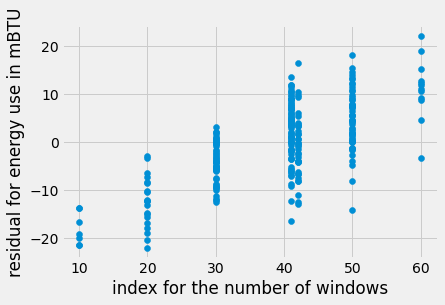

In [14]:
# compare difference between model-1 and model-2 as a function of window

dy = y2_pred - y_pred # dy is posivie if model-1 prediction is higher than model-2

print('type of dy is {}'.format(type(dy)))

windows = NE['WINDOWS']
print('type of windows is {}'.format(type(windows)))

x = windows.values # this converts panda dataframe to numpy array

plt.scatter(x,dy/1000)
plt.xlabel("index for the number of windows")
plt.ylabel("residual for energy use in mBTU")
plt.show()

It appears the number of windows is related to energy usage! Larger the number of windows, model 2 predict higher energy use. 
The number of windows can make a 20 mBTU difference which is very significant. Thus, I will include number of windows in my linear regression model.

## Using the Model to Predict Energy Usage

In [15]:
NE[['NHSLDMEM',"TOTHSQFT",'Income', 'YEARMADERANGE', 'TOTROOMS', 'WINDOWS']].head()

,NHSLDMEM,TOTHSQFT,Income,YEARMADERANGE,TOTROOMS,WINDOWS
5,1,623,10,5,1,20
10,1,1426,50,3,5,41
43,3,811,70,5,4,20
45,3,1955,90,5,6,41
54,1,2009,110,5,5,42


In [16]:
# This is an example of a household I came up with. Feel free to input your information here to estimate your energy usage!
test = np.array([[1, 1426, 50, 3, 5, 20]])
print(model2.predict(test))

[32484.19586005]


## Calculating Carbon Emissions

Pounds of CO2 emitted per million British thermal units (Btu) of energy for various fuels

- Coal (anthracite)	    228.60
- Coal (bituminous)	    205.40
- Coal (lignite)	    216.24
- Coal (subbituminous)	    214.13
- Diesel fuel and heating oil	    163.45
- Gasoline (without ethanol)	    155.77
- Propane	    138.63
- Natural gas	    116.65

Electric was a little harder because emmisions depend on the source. I used an average to get 249.11


https://www.eia.gov/tools/faqs/faq.php?id=73&t=11

In [17]:
#Energy to CO2 Emissions Conversions (in lbs)

ELCARBON = NE['BTUELSPH'] / 1000 * 249.11
# Natural Gas
NGCARBON = NE['BTUNGSPH'] / 1000 * 116.65
# Propane 
LPCARBON = NE['BTULPSPH'] / 1000 * 138.63
# Oil/Kerosene
FOCARBON = NE['BTUFOSPH'] / 1000 * 163.45

I wanted to see which energy sources were most intensive. I also used the energy used vs cost graph to see if there was any relationship between carbon emissions and price. Ideally, if you take into account the externality of carbon emissions, more carbon intensive energy sources should cost more for the consumer because they have a high cost to society.

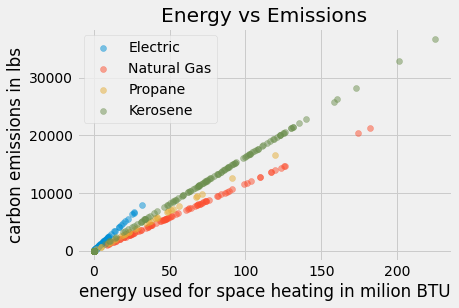

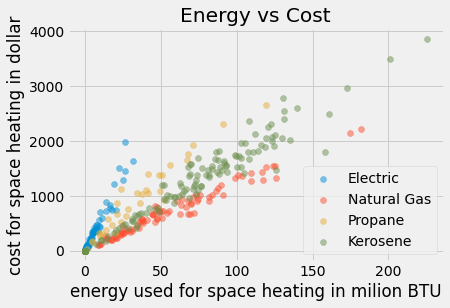

In [18]:
EL = plt.scatter(NE['BTUELSPH']/1000, ELCARBON, alpha = .5)
NG = plt.scatter(NE['BTUNGSPH']/1000, NGCARBON, alpha = .5)
LP = plt.scatter(NE['BTULPSPH']/1000, LPCARBON, alpha = .5)
FO = plt.scatter(NE['BTUFOSPH']/1000, FOCARBON, alpha = .5)

plt.legend((EL, NG, LP, FO), ('Electric', 'Natural Gas', 'Propane', 'Kerosene'))
plt.xlabel("energy used for space heating in milion BTU")
plt.ylabel("carbon emissions in lbs")
plt.title('Energy vs Emissions')
plt.show()

EL = plt.scatter(NE["BTUELSPH"]/1000, NE["DOLELSPH"], alpha = .5)
NG = plt.scatter(NE['BTUNGSPH']/1000, NE['DOLNGSPH'], alpha = .5)
LP = plt.scatter(NE['BTULPSPH']/1000, NE['DOLLPSPH'], alpha = .5)
FO = plt.scatter(NE['BTUFOSPH']/1000, NE['DOLFOSPH'], alpha = .5)

plt.legend((EL, NG, LP, FO), ('Electric', 'Natural Gas', 'Propane', 'Kerosene'), loc=4)
plt.xlabel("energy used for space heating in milion BTU")
plt.ylabel("cost for space heating in dollar")
plt.title('Energy vs Cost')

plt.show()

I find that electricity is most carbon intensive, most expensive, and least popular which makes sense. Less people will use the more expensive service. 

## Emissions and Income
The following functions are used to calculate carbon emissions in a household. 

In [19]:
def calculate_carbon(warm, energy_used):
    if warm == "EL" or warm == "ELWARM":
        return(energy_used / 1000 * 249.11)
    if warm == "NG" or warm == "NGWARM":
        return(energy_used / 1000 * 116.65)
    if warm == "LP" or warm == "LPWARM":
        return(energy_used / 1000 * 138.63)
    if warm == "FO" or warm == "FOWARM":
        return(energy_used / 1000 * 163.45)

In [20]:
def calculate_tax(carbon_emissions, dollars):
    return(carbon_emissions/2000 * dollars)

In [21]:
test = np.array([[1, 1426, 50, 3, 5, 20]])
print(model2.predict(test))
carbon = calculate_carbon("EL", model2.predict(test))
print("Carbon Emissions in lbs ${}".format(carbon))
print("Price of Carbon Tax ${}".format(calculate_tax(carbon, 20)))

[32484.19586005]
Carbon Emissions in lbs $[8092.1380307]
Price of Carbon Tax $[80.92138031]


## The Burden of a Carbon Tax
I recreated the "Energy Usage and Income" graphs using carbon emissions rather than energy to visualize the relationship between income and carbon emissions (and hypothetical price of taxes). 

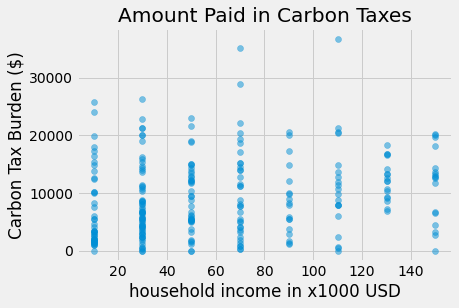

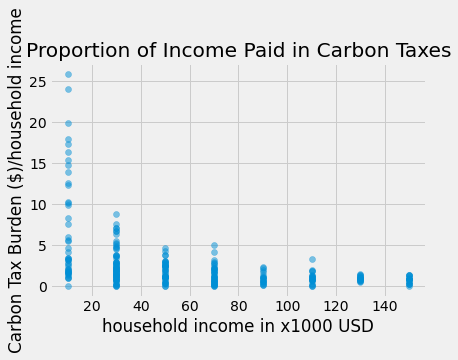

In [22]:
df2 = df.copy();

# calculate energy usage per Capita
df2['BTU_perCapita'] = df['TOTALBTUSPH']/df['NHSLDMEM']

# calculate carbon emissions
TOTCARBON = ELCARBON + NGCARBON + FOCARBON + LPCARBON

# convert MONEYPY to household income in thousand dollars
df2['Income'] = (df['MONEYPY']-1)*20+10 

plt.scatter(NE['Income'], TOTCARBON, alpha = .5)
plt.xlabel("household income in x1000 USD")
plt.ylabel("Carbon Tax Burden ($)")
plt.title('Amount Paid in Carbon Taxes')
plt.show()

# Cost of Carbon Tax at $20/ton
COST_OF_TAX = TOTCARBON / 2000 * 20

plt.scatter(NE['Income'], COST_OF_TAX/NE['Income'], alpha = .5)
plt.xlabel("household income in x1000 USD")
plt.ylabel("Carbon Tax Burden ($)/household income")
plt.title('Proportion of Income Paid in Carbon Taxes')
plt.show()


It is interesting how the graph of energy used for space heating vs cost and carbon emissions is very similar. This suggests that high carbon emitting sources of energy such as electricity also cost more. Contrastingly, natural gas emits the least amount of carbon and is the least expensive.

If we think about a carbon tax, households that emit more will be more impacted by the tax. Thus, households that use electric space heating will pay more in taxes than those that use natural gas. Here I will replicate the graphs that compare income to cost of space heating to see if a carbon tax becomes less or more regressive.

These scatter plots show similar trends to the previous plots of cost of energy / income. 

From this data, I conclude that regardless of household income, the carbon emissions of space heating remain relatively similar. Furthermore, people with lower household income would pay proportionally more in carbon taxes. This model assumes a $20 per ton carbon tax and assumes that consumers would carry 100% of the burden of the tax.

This raises the question of whether carbon pricing is environmentally just because it is a regressive tax that places a larger burden on lower income households. Although this model only represents carbon emissions from space heating, the trend generally holds true along other carbon emitting factors. Thus, there is a international debate about where the revenue from the carbon tax should go. 

### A Carbon Tax Would be Progressive 
https://thehill.com/opinion/energy-environment/550691-economists-a-us-carbon-tax-would-be-progressive

- A carbon tax at its root is regressive because it desproportionately burdens low-income households. 
- However, the industries will bear some of the impact of the cost. *As I learned in my economics class, because demand for energy is inelastic, industries will bear af significant portion of the burden. Because shareholders of carbon producing industries have higher incomes, taxing them would be progressive. The loss of capital from taxation on the producer side is not taken into account in my scatter plot 
["Proportion of Income Paid in Carbon Taxes."](#The-Burden-of-a-Carbon-Tax)*
- Lower income households benefit more from transfer programssuch as Social Security and food assistance from SNAP. These programs would not beinpacted by the carbon price, and thus this specific burden would not fall on lower income households that use government assistance programs.
- Health benefits of decreasing carbon pollution benefits low-income households more. (Progressive impact)
- Other alternatives (regualtion, subsidies) are less progressive than a carbon tax and dividend. 

### How Regressive is a Price on Carbon?
https://www.nber.org/digest/jan10/how-regressive-price-carbon

- Lower income people pay a greater proportion of their income on energy than higher income families.
- The lowest 1/5 of the income distribution would face a burden 1.4-4 times greater than householdsis the top 1/5.
- The burden on the poorest households doubles when the carbon price is not narrowly targeted and broadly encompasses all industries. *ex. perhaps carbon emissions from luxury goods should be taxed at a higher rate (ie pools and private jets) as opposed to household heating.*
- At 15 dollars a ton, the bottom 1/5 spend an extra 325 dollars a year, and the top 1/5 would pay around 1000 dollars a year.
- However, housholds in the top 1/5 earn 10 times more than the lowest 1/5 - burden would be four times higher
- 4 times greater burden in a year, 1.4 times greater burden in a lifetime. *this is due to increasing income throughout lifetime*
- A 15 dollar per ton tax would raise around 79 billion dollars annually. This revenue could be distributed especially to low income households that are most impacted by the tax.

### Carbon Fee and Dividend (EICDA)
https://citizensclimatelobby.org/laser-talks/carbon-fee-dividend-laser-talk/
https://citizensclimatelobby.org/laser-talks/low-income-households-and-carbon-fee-and-dividend/

**I am a part of Citizen's Climate Lobby as the co-head of their national youth action team. They lobby primarily for a Carbon Fee and Dividend.**

- Fee starting as 15 dollars a ton, increasing by 10 dollars every year.
- Net proceed divided equally per person. 
- 58% of taxpayers would recieve more money than the excess they spend due to the tax.

- "Low-income" Americans come out ahead 96% of the time. *Low income is defined as earning 80% or lessof the median family income.*

https://citizensclimatelobby.org/wp-content/uploads/2018/06/HIS2-Working-Paper-v1.1.pdf


*This study shows data from simulations of the proposed carbon fee and dividend.*
- Median net benefit of all households is -31 dollars
- First quintile median benefit is 241 dollars (followed by 129, 53, -42, -538)
- 3% of first quintile loses money (followed by 11%, 24%, 40%, and 42%)

### Green Future Now Act (GFN)
https://drive.google.com/drive/search?q=green%20future%20now
https://docs.google.com/document/d/1KvTGTGF-Ra2z2IxQmEsqCzgSgQXgPO-TTtmcjcvNWvQ/edit

**I am also a field representative for Our Climate Massachusetts and Andover Climate Lobby's representative at the Massachusetts Youth Climate Coalition. We lobby for environmentally just state level policy.**

- Raises money by eliminating the polluter fee loophole. Charges polluters for their pollution.
- Funding breakdown
    - 22% Local Green Investments
    - 52% Statewide Green Infrastructure
    - 24% Household Dividends
    - At least 60% of the revenue must used to invest in EJ populations.

- Dividends go to bottom 40% of households. 95% of those households have net zero or net positive result.

### Connections
The GFN is more intentional about making sure that the tax is not regressive. 
Although fundementally a carbon tax is regressive, by distributing some or all of the revenue, it can be progressive.

## Emissions and Race

I wanted to see if there was a relationship between race and energy used or carbon emitted. First, I wanted to check if there was enough data to make accurate reflections

In [23]:
NE[NE["HOUSEHOLDER_RACE"]==1].describe()

,KWH,TOTALDOLSPH,TOTALBTUSPH,NHSLDMEM,TOTHSQFT,YEARMADERANGE,DOLELSPH,BTUELSPH,DOLNGSPH,BTUNGSPH,...,REGIONC,DIVISION,TOTROOMS,HOUSEHOLDER_RACE,BTU_perCapita,fEL,fNG,fLP,fFO,Income
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,...,225.0,225.0,225.000000,225.0,225.000000,218.000000,218.000000,218.000000,218.000000,225.000000
mean,7784.056444,1122.877333,63122.084418,2.382222,1992.511111,3.448889,88.297289,1668.747524,235.372578,18221.626916,...,1.0,1.0,6.217778,1.0,31344.664373,0.080283,0.332386,0.112820,0.474511,62.800000
std,4928.540098,773.110709,43032.522145,1.223156,1124.506614,2.221709,238.665887,4578.664680,425.427411,33605.662308,...,0.0,0.0,2.287709,0.0,25838.836936,0.247019,0.466600,0.306608,0.488583,42.925184
min,186.500000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000
25%,4166.190000,473.600000,30914.302000,1.000000,1144.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,5.000000,1.0,13924.510000,0.000000,0.000000,0.000000,0.000000,30.000000
50%,7089.262000,1041.680000,55844.779000,2.000000,1847.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,6.000000,1.0,25290.321000,0.000000,0.000000,0.000000,0.000000,50.000000
75%,10218.069000,1570.430000,90583.138000,3.000000,2634.000000,5.000000,25.680000,451.649000,332.410000,24991.866000,...,1.0,1.0,8.000000,1.0,40690.934000,0.007631,1.000000,0.000000,1.000000,90.000000
max,29996.227000,3947.710000,225135.643000,7.000000,6261.000000,8.000000,1644.110000,31546.444000,2222.120000,182111.623000,...,1.0,1.0,14.000000,1.0,160566.016000,1.000000,1.000000,1.000000,1.000000,150.000000


In [24]:
# Here I found that there were 0 data points for Asian people
NE[NE["HOUSEHOLDER_RACE"]==4].head()

,KWH,TOTALDOLSPH,TOTALBTUSPH,NHSLDMEM,TOTHSQFT,YEARMADERANGE,DOLELSPH,BTUELSPH,DOLNGSPH,BTUNGSPH,...,REGIONC,DIVISION,TOTROOMS,HOUSEHOLDER_RACE,BTU_perCapita,fEL,fNG,fLP,fFO,Income


I wanted to use race to see if there was any correlation between race and how much of one's income one would spend on carbon taxes. However, I found that the overwhelming number of data points was of white people, and there were no data points on Asian, Native Hawaian or other Pacific Islander. Thus, I chose not to use race because there was too little data.

So, I decided to broaden to the entire data set, not just in New England.

In [25]:
df[df["HOUSEHOLDER_RACE"]==4].describe()

,KWH,TOTALDOLSPH,TOTALBTUSPH,NHSLDMEM,TOTHSQFT,YEARMADERANGE,DOLELSPH,BTUELSPH,DOLNGSPH,BTUNGSPH,...,MONEYPY,ELWARM,UGWARM,LPWARM,WINDOWS,TYPEHUQ,REGIONC,DIVISION,TOTROOMS,HOUSEHOLDER_RACE
count,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,...,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.0
mean,7145.881074,332.856818,25491.446326,2.913223,1696.561983,4.677686,92.269545,2260.817165,215.260496,22134.454050,...,4.727273,0.438017,0.619835,0.016529,33.243802,3.053719,3.057851,6.892562,5.814050,4.0
std,4838.801496,352.830782,34562.150631,1.444948,1388.693056,2.115797,208.802115,5170.788808,288.737934,34944.183264,...,2.410213,0.497171,0.486433,0.127762,13.136787,1.323741,1.121628,3.291638,2.781558,0.0
min,843.153000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,10.000000,1.000000,1.000000,2.000000,1.000000,4.0
25%,3582.040000,67.187500,3077.719250,2.000000,785.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,3.000000,4.000000,4.0
50%,5952.172500,208.755000,12416.597000,3.000000,1356.500000,5.000000,0.000000,0.000000,98.940000,8144.943500,...,5.000000,0.000000,1.000000,0.000000,30.000000,2.000000,4.000000,8.000000,6.000000,4.0
75%,9029.531500,474.737500,33458.435500,4.000000,2309.750000,7.000000,76.430000,1831.998500,370.585000,30691.873250,...,7.000000,1.000000,1.000000,0.000000,41.000000,5.000000,4.000000,10.000000,8.000000,4.0
max,29442.280000,1955.940000,269364.733000,8.000000,7878.000000,8.000000,1597.060000,31488.997000,1601.120000,269364.733000,...,8.000000,1.000000,1.000000,1.000000,60.000000,5.000000,4.000000,10.000000,13.000000,4.0


Here, I graphed Race vs KWH to see the relationship

<AxesSubplot:xlabel='HOUSEHOLDER_RACE', ylabel='KWH'>

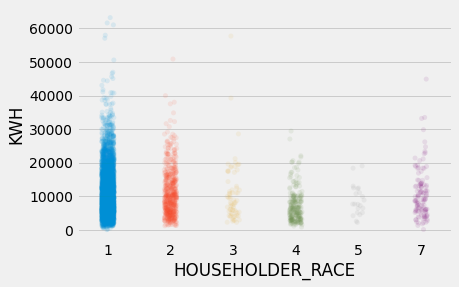

In [26]:
sns.stripplot(x="HOUSEHOLDER_RACE", y="KWH", data=df, alpha = .1)

This plot was a little difficult to see because there was a different number of data points for each race. So, I decided to pull 20 random data points from each group to make trends easier to see.

Text(0, 0.5, 'KW Used')

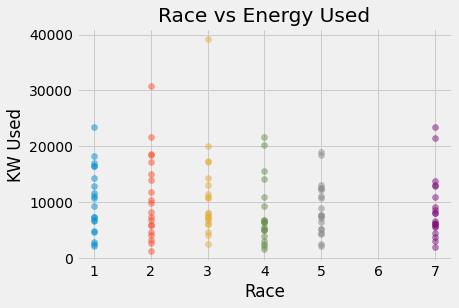

In [27]:
sample_size = 20
df_race1 = df[df.HOUSEHOLDER_RACE == 1].sample(n=sample_size)
df_race2 = df[df.HOUSEHOLDER_RACE == 2].sample(n=sample_size)
df_race3 = df[df.HOUSEHOLDER_RACE == 3].sample(n=sample_size)
df_race4 = df[df.HOUSEHOLDER_RACE == 4].sample(n=sample_size)
df_race5 = df[df.HOUSEHOLDER_RACE == 5].sample(n=sample_size)
df_race7 = df[df.HOUSEHOLDER_RACE == 7].sample(n=sample_size)

plt.scatter(df_race1['HOUSEHOLDER_RACE'], df_race1['KWH'], alpha = .5)
plt.scatter(df_race2['HOUSEHOLDER_RACE'], df_race2['KWH'], alpha = .5)
plt.scatter(df_race3['HOUSEHOLDER_RACE'], df_race3['KWH'], alpha = .5)
plt.scatter(df_race4['HOUSEHOLDER_RACE'], df_race4['KWH'], alpha = .5)
plt.scatter(df_race5['HOUSEHOLDER_RACE'], df_race5['KWH'], alpha = .5)
plt.scatter(df_race7['HOUSEHOLDER_RACE'], df_race7['KWH'], alpha = .5)
plt.title("Race vs Energy Used")
plt.xlabel("Race")
plt.ylabel("KW Used")
# Race categories are listed at the top of the notebooks in "Useful Variables"

# Here is seems like there is not much difference between households based on race
# Thus, a carbon tax would likely be more discriminatory based on income rather than race

However, from this graph it seems that there is no correlation between race and energy usage.

## Miscellaneous Sources

### For debugging:

https://stackoverflow.com/questions/36921951/truth-value-of-a-series-is-ambiguous-use-a-empty-a-bool-a-item-a-any-o
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.append.html
https://stackoverflow.com/questions/39815646/pandas-append-dataframe-to-another-df
https://datatofish.com/random-rows-pandas-dataframe/
https://www.markdownguide.org/basic-syntax/#escaping-backticks
https://www.markdownguide.org/extended-syntax/
https://www.markdownguide.org/cheat-sheet/
https://datascience.stackexchange.com/questions/20199/train-test-split-error-found-input-variables-with-inconsistent-numbers-of-sam
https://stats.stackexchange.com/questions/286709/do-you-need-to-split-data-for-linear-regression
https://numpy.org/doc/stable/reference/generated/numpy.array.html
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
https://www.kite.com/python/docs/random.shuffle
https://seaborn.pydata.org/generated/seaborn.stripplot.html
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html#matplotlib.pyplot.bar
https://matplotlib.org/stable/tutorials/introductory/pyplot.html
https://scikit-learn.org/stable/visualizations.html
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
https://www.analyticsvidhya.com/blog/2021/05/multiple-linear-regression-using-python-and-scikit-learn/
https://www.w3schools.com/python/python_ml_multiple_regression.asp

### Help from people
- Asked Dr. Z for support and questions throughout
- Dr. Z's data modeling and polynomial regression videos
- Called my dad about the logistic regression model that wasn't quite working.

# Conclusion

**Implications and applications:**
I created a method of prediction for energy usage and carbon emissions for a household with practical uses in mind. I think that a similar program could be used as a calculator that people can use to predict how much they will pay and stand to gain/lose in carbon taxes. I think this will be important to grow support and advocacy for carbon pricing.

With a dividend, most citizens will actually benefit from a carbon tax financially in the short term. Many people think that they will just be losing money to the government, which does not have to be true. Also, in the long run, everyone will benefit from a reduction of carbon emissions, particularly lower-income households.

Thus, keeping this application in mind, I decided not to include race as one of my predictors for energy usage. This is because including race, which is not inherently related to energy usage, could creates biases in the predictions and result in racial minorities paying or believe they will pay the incorrect amount in taxes. 

However, in my "Race and Emissions" sections, I found that race actually had very little to no correlation with energy usage, so it would likely not have been relevant anyway. 

# What Didn't Quite Work Out
Here, I was trying to predict what type of energy a household was using for space heating through linear regression. It wasn't very accurate or useful, so I decided to move on.

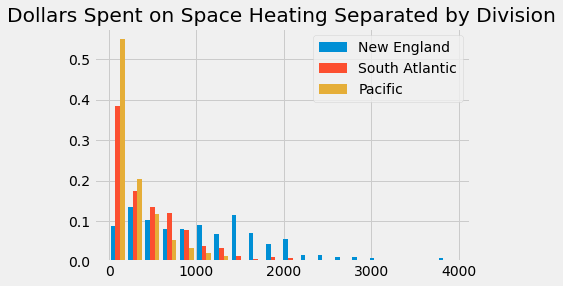

In [28]:
# Separating data by Division, found that NE households spend more on space heating than south atlantic and pacific
NE = df[df.DIVISION == 1]
SA = df[df.DIVISION == 5]
PA = df[df.DIVISION == 10]

# Does not yet include other sources of fuel
# other = df[[df.ELWARM == 0],[df.UGWARM == 0],[df.LPWARM == 0]]

wNE = np.ones(len(NE))/len(NE)
wSA = np.ones(len(SA))/len(SA)
wPA = np.ones(len(PA))/len(PA)

plt.hist([NE.TOTALDOLSPH, SA.TOTALDOLSPH, PA.TOTALDOLSPH], 
         weights = [wNE, wSA, wPA], 
         label=['New England', 'South Atlantic', 'Pacific'], 
         bins=20)

plt.legend()
plt.title('Dollars Spent on Space Heating Separated by Division')
plt.show()


Below, I did the same analysis with KW used per household. I found that the trends for the different types of energy used for space heating were all in a very similar bell curve shape. However, the peaks seem to be in the same areas, so it is likely that KW used is not a predictor for type of energy used.

Here are the scatter plots that compare the income, energy usage, and money spent on space heating between households that use electricity vs other forms of energy for space heating. 

Some of the trends I see are that households that use more KWH use electricity. This can be shown from the first and second graphs. Total dollars spent on space heating do not seem to be a predictor.

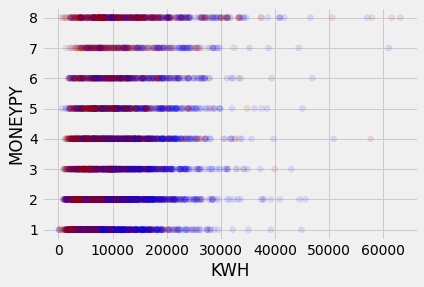

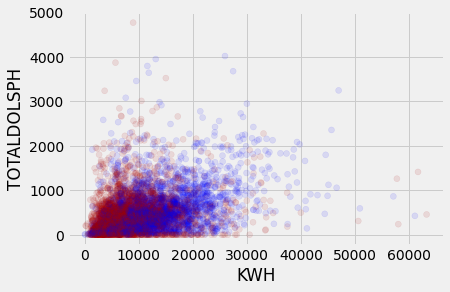

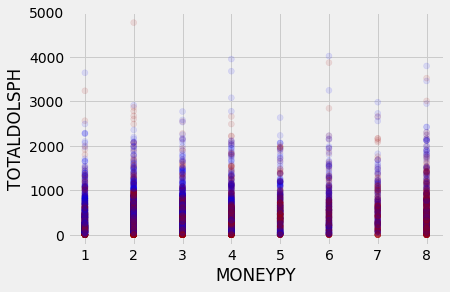

In [29]:
colormap = {0: '#aa0000', 1: 'b'}
preds = ['KWH', 'MONEYPY','TOTALDOLSPH']
for x, y in (combinations(preds, 2)):
    plt.scatter(df[x], df[y], c = df.ELWARM.map(colormap), alpha = .1)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

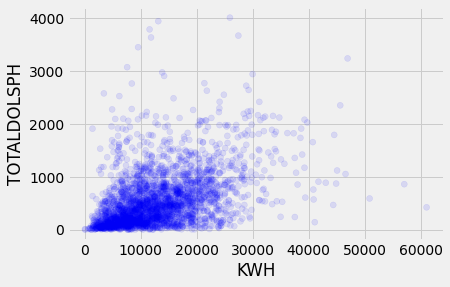

In [30]:
# Graph of electric households compared to kw uesd and total dollars spent on space heating
colormap = {0: '#aa0000', 1: 'b'}
electric = df[df.ELWARM == 1]
preds = ['KWH', 'TOTALDOLSPH']
for x, y in (combinations(preds, 2)):
    plt.scatter(electric[x], electric[y], c = electric.ELWARM.map(colormap), alpha = .1)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

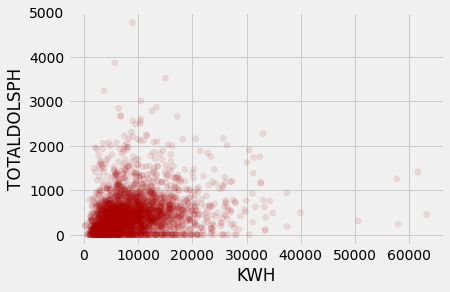

In [31]:
# Graph of non electric households compared to kw uesd and total dollars spent on space heating
not_electric = df[df.ELWARM == 0]
preds = ['KWH', 'TOTALDOLSPH']
for x, y in (combinations(preds, 2)):
    plt.scatter(not_electric[x], not_electric[y], c = not_electric.ELWARM.map(colormap), alpha = .1)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()
    

I can see that electric households use more kw of energy and spend more on space heating. Thus, this can be used as a predictor. However, because many of the data points overlap in the cluster, it will be difficult to differentiate them. I wonder if I can use another data set to make more accurate predictions.

From here on is what I am not yet finished nor comfortable with.

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression

# this splits the dataset to training and test
model_1_preds = ['KWH','TOTALDOLSPH', 'MONEYPY'] 
X_train, X_test, y_train, y_test = train_test_split(NE[model_1_preds], NE.ELWARM, test_size=.3)

print("the shape of X_train is", X_train.shape)
print("the shape of X_test is", X_test.shape)

# there are two models, 1 uses three parameters, and 2 uses only one
model_1 = LogisticRegression().fit(X_train, y_train)
model_2 = LogisticRegression().fit(X_train[['KWH']], y_train) # Wrap double brackets or reshape(-1,1)

score1 = model_1.score(X_test, y_test)
score2 = model_2.score(X_test[['KWH']], y_test)

print("score for the model uses kwh, total $ spent, and money py: {:.2f}".format(score1))
print("score for the model uses only kwh: {:.2f}".format(score2))

the shape of X_train is (177, 3)
the shape of X_test is (76, 3)
score for the model uses kwh, total $ spent, and money py: 0.67
score for the model uses only kwh: 0.66


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression

# this splits the dataset to training and test
model_1_preds = ['KWH','TOTALDOLSPH', 'MONEYPY', 'DIVISION'] 
X_train, X_test, y_train, y_test = train_test_split(df[model_1_preds], df.ELWARM, test_size=.3)


In [34]:
print("the shape of X_train is", X_train.shape)
print("the shape of X_test is", X_test.shape)

the shape of X_train is (3980, 4)
the shape of X_test is (1706, 4)


In [35]:
# there are two models, 1 uses three parameters, and 2 uses only one
model_1 = LogisticRegression().fit(X_train, y_train)
model_2 = LogisticRegression().fit(X_train[['KWH']], y_train) # Wrap double brackets or reshape(-1,1)

In [36]:
score1 = model_1.score(X_test, y_test)
score2 = model_2.score(X_test[['KWH']], y_test)

print("score for the model uses kwh, total $ spent, and money py: {:.2f}".format(score1))
print("score for the model uses only kwh: {:.2f}".format(score2))

score for the model uses kwh, total $ spent, and money py: 0.64
score for the model uses only kwh: 0.50


In [37]:
df = raw_df[["KWH","TOTALDOLSPH","MONEYPY","ELWARM","UGWARM","LPWARM","TOTROOMS","WINDOWS","DIVISION"]]
df.head(10) # look at the first 10 data

,KWH,TOTALDOLSPH,MONEYPY,ELWARM,UGWARM,LPWARM,TOTROOMS,WINDOWS,DIVISION
0,5270.742,176.59,8,0,1,0,7,41,10
1,12173.000,380.52,2,1,0,0,4,20,7
2,19655.394,601.17,2,1,1,0,9,41,6
3,9852.535,863.46,3,1,0,1,7,42,4
4,3115.655,67.87,3,0,1,0,6,30,2
5,2777.000,266.70,1,0,0,1,1,20,1
6,2397.758,198.68,4,0,1,0,4,30,5
7,13890.899,512.95,3,0,1,0,5,30,3
8,10422.424,953.05,5,0,0,0,9,41,2
9,18505.802,274.13,6,1,0,0,6,42,7


In [38]:
colormap = {0: '#aa0000', 1: 'b'}

# this gets the values for model_1_preds = ['KWH','TOTALDOLSPH', 'MONEYPY']
X_data = df[model_1_preds].values
x_axis_name = 'KWH'
y_axis_name = 'TOTALDOLSPH'

# CONSTANTS
GRANULARITY = 50

#### CREATE PREDICTION SURFACES ####
# find min and max for KWH and TOTALDOLSPH

x1_min, x1_max, x2_min, x2_max = (df[x_axis_name].min(),
                                  df[x_axis_name].max(),
                                  df[y_axis_name].min(),
                                  df[y_axis_name].max())
# make meshgrid of 50x50
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, GRANULARITY),
                       np.linspace(x2_min, x2_max, GRANULARITY))

# ravel will convert matrix to 1D array. this makes a vector of 2500x1
xx1_col = xx1.ravel()
xx2_col = xx2.ravel()

# use numpy to make a matrix with columns this makes 2500x3 matrix
X_columns_1 = np.c_[xx1_col, xx2_col, np.zeros(xx1_col.shape)]
X_columns_2 = np.c_[xx1_col]

# model 1 used ['KWH','TOTALDOLSPH', 'MONEYPY'] 
# KWH: total site electricity usage in kilowatt-hours, 
# TOTALDOLSPH: total cost for space heating in whole dollars
# MONEYPY: gross househod income
# X_column_1 is a matrix with 
# column1: linearly spaced KWW
# column2: linearly spaced total cost for heating
# column3: array of zero so that gross household income is not used here. 

yy_1 = model_1.predict_proba(X_columns_1).T[0] #transpose 
yy_1 = yy_1.reshape(xx1.shape) # yy1 is 2500x1 array this makes it back to 50x50 matrix

# repeat for model2
yy_2 = model_2.predict_proba(X_columns_2).T[0]
yy_2 = yy_2.reshape(xx1.shape)

ValueError: X has 3 features per sample; expecting 4

Below, I can look at the predicted probability of electric heating vs. energy usage (KWH) and heating cost. It apepars the model predict high probability for low KWH and high heating cost to be electric heating. Does this mean electric heating is expensive?

/var/folders/0g/31flqnzd7f5bm7cmp4f3rqsw0000gp/T/ipykernel_3513/3581131868.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, elev=elev, azim=azim)


NameError: name 'yy_1' is not defined

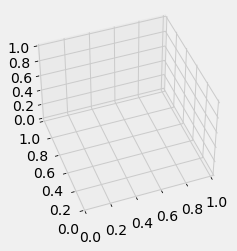

In [39]:
from mpl_toolkits.mplot3d import Axes3D
elev = 43.5
azim = -110
fig_num=1
fig = plt.figure(fig_num, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, elev=elev, azim=azim)

ax.scatter(xx1_col, xx2_col, yy_1, c="b", marker="+")
ax.set_xlabel("KWH")
ax.set_ylabel("heating cost")
ax.set_zlabel("probability of electric heating")

I added levels to contour plot so that you can see it better.

NameError: name 'yy_1' is not defined

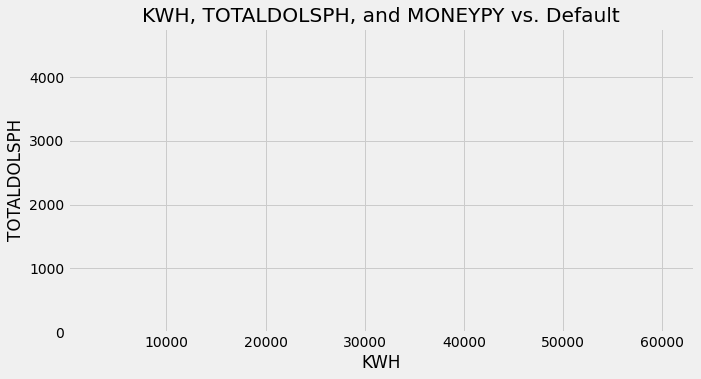

In [40]:
#### PLOTTING ####

figure = plt.figure(figsize=(10,12))
figure.subplots_adjust(hspace=.3) # This line adds some space between plots

## Model 1
ax1 = figure.add_subplot(2,1,1)

ax1.set_xlim(x1_min, x1_max)
ax1.set_ylim(x2_min, x2_max)
ax1.set_xlabel('KWH')
ax1.set_ylabel('TOTALDOLSPH')
ax1.set_title('KWH, TOTALDOLSPH, and MONEYPY vs. Default')

cs1 = ax1.contour(xx1, xx2, yy_1, levels=[.2, .4, .6]) # added more contour lines
ax1.clabel(cs1, inline=1, fontsize=20) # this adds to label to show contour levels
ax1.scatter(df[x_axis_name],df[y_axis_name], c = df.ELWARM.map(colormap), alpha=.1)

## Model 2
ax2 = figure.add_subplot(2,1,2)

ax2.set_xlim(x1_min, x1_max)
ax2.set_ylim(x2_min, x2_max)
ax2.set_xlabel('KWH')
ax2.set_ylabel('TOTALDOLSPH')
ax2.set_title('KWH vs. Default')

cs2 = ax2.contour(xx1, xx2, yy_2, levels=[.2, .4, .6])
ax2.clabel(cs2, inline=1, fontsize=20)
ax2.scatter(df[x_axis_name],df[y_axis_name], c = df.ELWARM.map(colormap), alpha=.1)

plt.show()

I think you cannot really use logical values (1 and 0) in linear regression models. your ELWARM, UGWARM and LPWARM are logical values. 

In [41]:
# Import the packages and classes needed in this example:
import numpy as np
from sklearn.linear_model import LinearRegression

# Create a numpy array of data:
# x = np.array([6, 16, 26, 36, 46, 56]).reshape((-1, 1))
# y = np.array([4, 23, 10, 12, 22, 35])
# print(x)
# print(X_columns_1)
# print(yy_2)
# print(df.KWH.to_numpy())
X = df[['TOTALDOLSPH', 'ELWARM',"UGWARM","LPWARM","TOTROOMS","WINDOWS"]]
y = df['KWH']

# Create an instance of a linear regression model and fit it to the data with the fit() function:
model = LinearRegression().fit(x, y) 

# The following section will get results by interpreting the created instance: 

# Obtain the coefficient of determination by calling the model with the score() function, then print the coefficient:
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)

# Print the Intercept:
print('intercept:', model.intercept_)
intercept = model.intercept_
# Print the Slope:
print('slope:', model.coef_) 
coef = model.coef_

# Predict a Response and print it:
y_pred = model.predict(x)
print('Predicted response:', y_pred, sep='\n')

print(model.predict([[1000], [1], [0], [0], [15], [5]]))


ValueError: Expected 2D array, got scalar array instead:
array=KWH.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [42]:
ax3 = figure.add_subplot(2,1,1)
ax3.scatter(x, y)
ax3.plot(x, np.sin(x));
plt.show()

ValueError: x and y must be the same size

In [43]:
plt.plot(x,x*model.coef_ + model.intercept_, color='g')

plt.scatter(x,y, alpha = .1)
plt.xlim(0, 60000)
plt.ylim(0, 5000)

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U3'), dtype('float64')) -> None

In [44]:
ax = sns.stripplot(x="ELWARM", y="KWH", data=test_dataset, alpha = .1)

# I can see from this strip plot that households that use electricity use more energy overall

NameError: name 'test_dataset' is not defined